In [1]:
# Setup
!git clone https://github.com/Sarthak16082/DDT
%cd DDT
!pip install lightning==2.5.0 torch torchvision torchaudio pyyaml diffusers timm datasets
!wget https://huggingface.co/MCG-NJU/DDT-XL-22en6de-R512/resolve/main/model.ckpt


Cloning into 'DDT'...
remote: Enumerating objects: 358, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 358 (delta 20), reused 22 (delta 18), pack-reused 327 (from 1)
Receiving objects: 100% (358/358), 17.36 MiB | 55.71 MiB/s, done.
Resolving deltas: 100% (181/181), done.
/kaggle/working/DDT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.3/815.3 kB 21.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.4 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Imports and Setup
import os, sys, json, requests, tarfile, random, gc, yaml, copy, io, contextlib
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Path fix
if not os.getcwd().endswith('DDT'):
    try: os.chdir('DDT')
    except: sys.exit("Error: Run from inside the DDT directory.")

In [3]:
# Config
DATA_DIR = "SPair-71k"
IMG_SIZE = 512
NUM_EVAL = 200
PCK_ALPHA = 0.1
CFG_PATH = "configs/repa_improved_ddt_xlen22de6_512.yaml"
CKPT_PATH = "model.ckpt"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Dataset setup
def setup_spair():
    url = "https://cvlab.postech.ac.kr/research/SPair-71k/data/SPair-71k.tar.gz"
    if os.path.isdir(DATA_DIR): return
    if not os.path.exists("SPair-71k.tar.gz"):
        r = requests.get(url, stream=True); r.raise_for_status()
        with open("SPair-71k.tar.gz", "wb") as f:
            for chunk in r.iter_content(8192): f.write(chunk)
    with tarfile.open("SPair-71k.tar.gz") as tar: tar.extractall()
setup_spair()

# Utils
def pck(pred, gt, bbox, alpha):
    thresh = alpha * max(bbox[2]-bbox[0], bbox[3]-bbox[1])
    return float(torch.norm(pred - gt) <= thresh)

In [5]:
# SPair category to ImageNet class mapping
CATEGORY_TO_CLASS = {
    'cat': 281,      # tabby, tabby cat
    'dog': 162,      # beagle 
    'bird': 15,      # robin, American robin
    'cow': 345,      # ox
    'horse': 339,    # sorrel
    'sheep': 348,    # ram, tup
    'aeroplane': 404, # airliner
    'bicycle': 444,   # bicycle-built-for-two, tandem bicycle, tandem
    'boat': 472,      # canoe
    'bottle': 440,    # beer bottle
    'bus': 779,       # school bus
    'car': 751,       # sports car, sport car
    'chair': 559,     # folding chair
    'diningtable': 532, # dining table, board
    'motorbike': 665,  # motor scooter, scooter
    'person': 380,     # titi, titi monkey
    'pottedplant': 859, # pot, flowerpot
    'sofa': 831,       # studio couch, day bed
    'train': 820,      # steam locomotive
    'tvmonitor': 851   # television, television system
}


In [6]:
# Feature Extractor with EMA weights and class conditioning
class DDTExtractor:
    def __init__(self, cfg_path, ckpt_path):
        cfg = yaml.safe_load(open(cfg_path))
        self.unconditional_token = cfg["model"]["denoiser"]["init_args"].get("num_classes", 1000)
        
        # Load components
        vae = self.instantiate_from_config(cfg["model"]["vae"])
        cond = self.instantiate_from_config(cfg["model"]["conditioner"])
        denoiser = self.instantiate_from_config(cfg["model"]["denoiser"])
        
        # Handle scheduler string reference
        sched_config = cfg["model"]["diffusion_sampler"]["init_args"]["scheduler"]
        if isinstance(sched_config, str):
            module_path, class_name = sched_config.rsplit(".", 1)
            module = __import__(module_path, fromlist=[class_name])
            sched = getattr(module, class_name)()
        else:
            sched = self.instantiate_from_config(sched_config)
        
        # Load EMA weights
        ckpt = torch.load(ckpt_path, map_location="cpu")
        denoiser = self.load_weights(denoiser, ckpt).to(DEVICE).eval()
        
        self.denoiser = denoiser
        self.vae = vae.to(DEVICE).eval()
        self.conditioner = cond
        self.scheduler = sched
        self.features = {}
        
        # Hook into Layer 21, the last encoder layer
        hook_layer = self.denoiser.blocks[21]
        hook_layer.register_forward_hook(lambda m, i, o: self.features.update({'feat': o[0] if isinstance(o, tuple) else o}))

    def instantiate_from_config(self, config):
        module_path, class_name = config["class_path"].rsplit(".", 1)
        module = __import__(module_path, fromlist=[class_name])
        return getattr(module, class_name)(**config.get("init_args", {}))

    def load_weights(self, model, checkpoint, prefix="ema_denoiser."):
        state_dict = checkpoint["state_dict"]
        loaded = 0
        for name, param in model.state_dict().items():
            full_name = prefix + name
            if full_name in state_dict:
                param.copy_(state_dict[full_name])
                loaded += 1
        print(f"Loaded {loaded} EMA weights.")
        return model

    def __call__(self, imgs, t_val, class_ids=None):
        b = imgs.shape[0]
        t = torch.full((b,), t_val, device=DEVICE)
        
        with torch.no_grad():
            enc = self.vae.encode(imgs.to(DEVICE))
            z = enc.sample() if hasattr(enc, "sample") else enc
            zt = self.scheduler.alpha(t).view(-1,1,1,1) * z + self.scheduler.sigma(t).view(-1,1,1,1) * torch.randn_like(z)
            
            # Class conditioning
            if class_ids is not None:
                class_tensor = torch.tensor(class_ids, device=DEVICE, dtype=torch.long)
            else:
                class_tensor = torch.full((b,), self.unconditional_token, device=DEVICE, dtype=torch.long)
                
            _ = self.denoiser(zt, t, class_tensor)
        return self.features['feat']


In [7]:
# Dataset - need the 512x512 resolution
class SPair(Dataset):
    def __init__(self, root, img_size):
        self.img_dir = os.path.join(root, 'JPEGImages')
        self.annot_dir = os.path.join(root, 'PairAnnotation', 'test')
        self.files = [os.path.join(self.annot_dir, f) for f in os.listdir(self.annot_dir) if f.endswith('.json')]
        random.shuffle(self.files)
        # Direct resize to target size
        self.tf = T.Compose([T.Resize((img_size, img_size)), T.ToTensor(),
                             T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


    def __len__(self): return len(self.files)

    def __getitem__(self, idx):
        d = json.load(open(self.files[idx]))
        if not d.get('src_kps') or not d.get('trg_kps'): return None
        img1 = Image.open(os.path.join(self.img_dir, d['category'], d['src_imname'])).convert("RGB")
        img2 = Image.open(os.path.join(self.img_dir, d['category'], d['trg_imname'])).convert("RGB")
        return {
            'src': self.tf(img1), 'ref': self.tf(img2),
            'src_kps': torch.tensor(d['src_kps']), 'ref_kps': torch.tensor(d['trg_kps']),
            'bbox': torch.tensor(d['trg_bndbox']), 'src_pil': img1, 'ref_pil': img2,
            'src_w': img1.width, 'src_h': img1.height, 'ref_w': img2.width, 'ref_h': img2.height,
            'category': d['category']
        }

In [8]:
# Collate
def collate(batch):
    batch = [b for b in batch if b]
    if not batch: return None
    imgs = {k: [b.pop(k) for b in batch] for k in ['src_pil', 'ref_pil']}
    data = torch.utils.data.dataloader.default_collate(batch)
    data.update(imgs)
    return data

In [14]:
# Simple Eval Function
def evaluate(feat_ext, loader, num, t):
    results, count = [], 0
    best, worst = {'score': -1}, {'score': 2}
    all_examples = []  # Store all examples with scores

    for b in loader:
        if count >= num: break
        if b is None: continue

        # Get class ID for conditioning
        category = b['category'][0]
        class_id = CATEGORY_TO_CLASS.get(category, feat_ext.unconditional_token)
        
        with contextlib.redirect_stdout(io.StringIO()):
            feats1 = feat_ext(b['src'], t, [class_id]).squeeze(0)
            feats2 = feat_ext(b['ref'], t, [class_id]).squeeze(0)

        Hf = int(feats1.shape[0] ** 0.5)
        kps = torch.stack([b['src_kps'][0][:,0] * Hf/b['src_w'][0], b['src_kps'][0][:,1] * Hf/b['src_h'][0]], -1).long().clamp(0, Hf-1)
        preds = []
        for kp in kps:
            idx = kp[1] * Hf + kp[0]
            sim = F.cosine_similarity(feats1[idx], feats2)
            best_idx = sim.argmax()
            preds.append([best_idx % Hf, best_idx // Hf])
        preds = (torch.tensor(preds, device=DEVICE) + 0.5) * torch.tensor([b['ref_w'][0]/Hf, b['ref_h'][0]/Hf], device=DEVICE)
        scores = [pck(preds[i].cpu(), b['ref_kps'][0][i], b['bbox'][0], PCK_ALPHA) for i in range(len(preds))]
        mean_score = np.mean(scores)
        
        # Store examples
        example = {
            'score': mean_score, 
            'batch': b, 
            'preds': preds.cpu(),
            'num_keypoints': len(b['src_kps'][0]),
            'individual_scores': scores
        }
        all_examples.append(example)
        
        # Only consider multi-keypoint examples for best/worst visualization
        if len(b['src_kps'][0]) >= 2:
            if mean_score > best['score']: best = example
            if mean_score < worst['score']: worst = example
        
        results.extend(scores)
        count += 1
    
    return {
        'best': best, 
        'worst': worst, 
        'mean_pck': np.mean(results)*100 if results else 0,
        'all_examples': all_examples
    }

In [10]:
# Load everything 
if not os.path.isfile(CKPT_PATH):
    print(f"Missing checkpoint at {CKPT_PATH}")
    exit()

print("Loading DDT model...")
with contextlib.redirect_stdout(io.StringIO()):
    feat_ext = DDTExtractor(CFG_PATH, CKPT_PATH)
print("Model loaded.")

print("Setting up data...")
data = SPair(DATA_DIR, IMG_SIZE)
loader = DataLoader(data, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate)
print(f"Data ready. Found {len(data)} image pairs.")


Loading DDT model...


2025-07-13 12:42:49.551626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752410569.729824      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752410569.780238      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Model loaded.
Setting up data...
Data ready. Found 12234 image pairs.


In [15]:
# Main Loop
timesteps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]  # 0-1 range, designed to test extremities
all_results = {}
outer_iterator = tqdm(timesteps, desc="Evaluating Timesteps")

for t in outer_iterator:
    all_results[t] = evaluate(feat_ext, loader, NUM_EVAL, t)
    outer_iterator.set_postfix_str(f"Last PCK (t={t}): {all_results[t]['mean_pck']:.2f}%")

# Results
print("\n--- Evaluation Complete ---")
for t, res in all_results.items():
    print(f"  Timestep {t}: Mean PCK = {res['mean_pck']:.2f}%")

Evaluating Timesteps: 100%|██████████| 10/10 [21:26<00:00, 128.70s/it, Last PCK (t=0.99): 9.29%]



--- Evaluation Complete ---
  Timestep 0.1: Mean PCK = 4.43%
  Timestep 0.2: Mean PCK = 5.91%
  Timestep 0.3: Mean PCK = 8.44%
  Timestep 0.4: Mean PCK = 9.43%
  Timestep 0.5: Mean PCK = 9.15%
  Timestep 0.6: Mean PCK = 10.91%
  Timestep 0.7: Mean PCK = 10.91%
  Timestep 0.8: Mean PCK = 10.56%
  Timestep 0.9: Mean PCK = 10.42%
  Timestep 0.99: Mean PCK = 9.29%


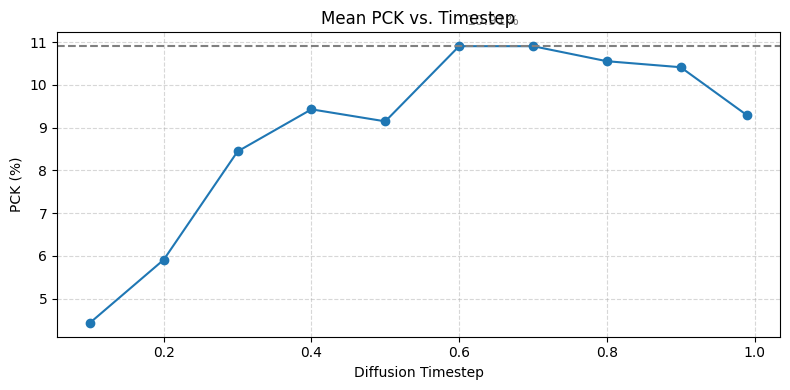

In [18]:
def plot_pck(results):
    if not results: return
    ts = sorted(results.keys())
    pcks = [results[t]['mean_pck'] for t in ts]
    peak = max(pcks)
    peak_t = ts[pcks.index(peak)]
    
    plt.figure(figsize=(8, 4))
    plt.plot(ts, pcks, marker='o', label='DDT PCK')
    plt.axhline(peak, color='grey', ls='--')
    y_min = min(pcks)
    plt.text(peak_t + 0.15, y_min + (peak - y_min) * 0.3, f'Peak: {peak:.2f}%', color='grey')
    plt.xlabel('Diffusion Timestep')
    plt.ylabel('PCK (%)')
    plt.title('Mean PCK vs. Timestep')
    plt.grid(True, ls='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    
def show_corr(result, title, ax):
    b = result['batch']
    draw(ax, b['src_pil'][0], b['ref_pil'][0],
         b['src_kps'][0].numpy(), b['ref_kps'][0].numpy(),
         result['preds'].numpy(), b['bbox'][0].numpy())
    ax.set_title(f"{title} (PCK: {result['score']*100:.1f}%)")

def draw(ax, src_img, ref_img, skps, rkps_gt, rkps_pred, bbox):
    w1, h1 = src_img.size
    combined = Image.new('RGB', (w1 + ref_img.width, max(h1, ref_img.height)))
    combined.paste(src_img, (0, 0))
    combined.paste(ref_img, (w1, 0))
    ax.imshow(combined)
    ax.axis('off')
    for s, pred, gt in zip(skps, rkps_pred, rkps_gt):
        color = 'limegreen' if pck(torch.tensor(pred), torch.tensor(gt), torch.tensor(bbox), PCK_ALPHA) else 'red'
        ax.add_line(mlines.Line2D([s[0], pred[0] + w1], [s[1], pred[1]], color=color, lw=1))

plot_pck(all_results)

Best multi-keypoint example: 83.3% PCK with 6 keypoints
Worst multi-keypoint example: 0.0% PCK with 5 keypoints


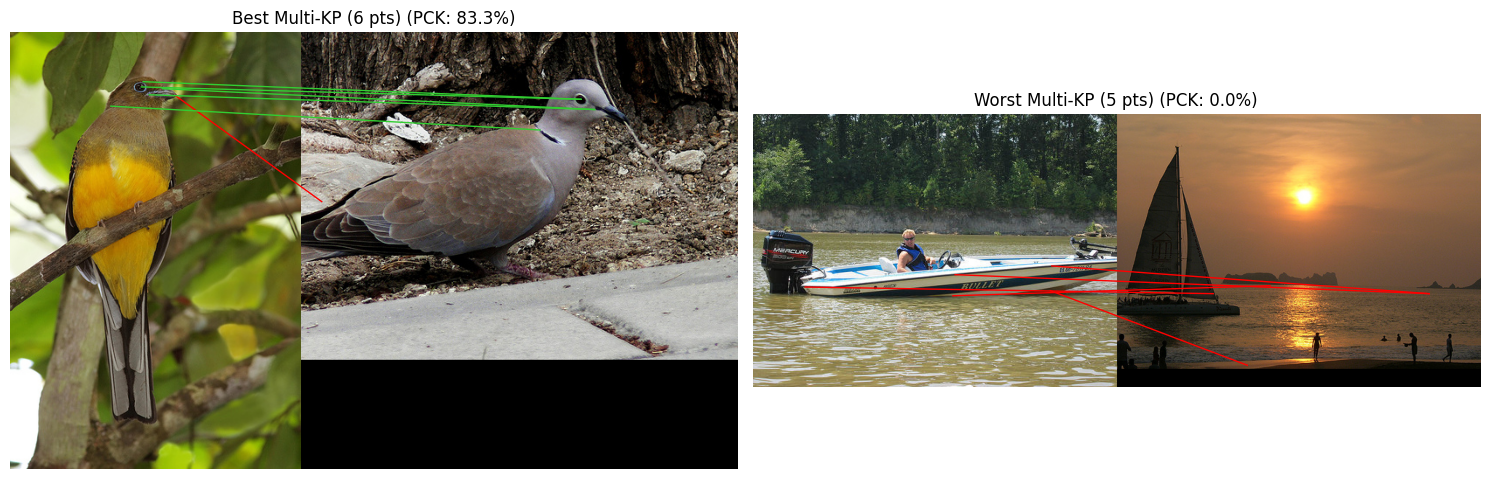

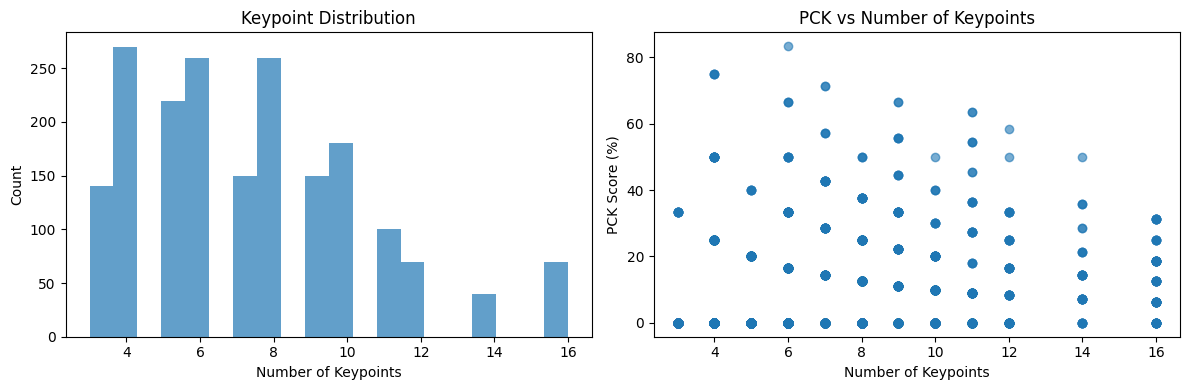

In [17]:
# Getting a single KP right is easier, plot for multiple KPs only, the Min is set to 2
# Just for curiosity, also get the distribution..
def plot_best_multi_keypoint(all_results, min_keypoints=2):
    # Collect all examples with at least min_keypoints
    multi_kp_examples = []
    for t, res in all_results.items():
        if 'all_examples' in res:
            for ex in res['all_examples']:
                if ex['num_keypoints'] >= min_keypoints:
                    multi_kp_examples.append(ex)
    
    if not multi_kp_examples:
        print(f"No examples found with at least {min_keypoints} keypoints")
        return
    
    # Sort by score and get best and worst
    multi_kp_examples.sort(key=lambda x: x['score'], reverse=True)
    best_multi = multi_kp_examples[0]
    worst_multi = multi_kp_examples[-1]
    
    print(f"Best multi-keypoint example: {best_multi['score']*100:.1f}% PCK with {best_multi['num_keypoints']} keypoints")
    print(f"Worst multi-keypoint example: {worst_multi['score']*100:.1f}% PCK with {worst_multi['num_keypoints']} keypoints")
    
    # Plot them
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    show_corr(best_multi, f"Best Multi-KP ({best_multi['num_keypoints']} pts)", axs[0])
    show_corr(worst_multi, f"Worst Multi-KP ({worst_multi['num_keypoints']} pts)", axs[1])
    plt.tight_layout()
    plt.show()
    
    # Show distribution
    kp_counts = [ex['num_keypoints'] for ex in multi_kp_examples]
    scores = [ex['score']*100 for ex in multi_kp_examples]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.hist(kp_counts, bins=20, alpha=0.7)
    ax1.set_xlabel('Number of Keypoints')
    ax1.set_ylabel('Count')
    ax1.set_title('Keypoint Distribution')
    
    ax2.scatter(kp_counts, scores, alpha=0.6)
    ax2.set_xlabel('Number of Keypoints') 
    ax2.set_ylabel('PCK Score (%)')
    ax2.set_title('PCK vs Number of Keypoints')
    plt.tight_layout()
    plt.show()

# Use it
plot_best_multi_keypoint(all_results, min_keypoints=3)  